<a href="https://colab.research.google.com/github/YUMVOLKOVA/dul_2021/blob/main/hw8/Homework8_DRE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!unzip -qq dul_2021/Homework/hw1/data/hw1_data.zip -d dul_2021/Homework/hw1/data/
!mv -v dul_2021/Homework/hw1/data/hw1_data/* dul_2021/Homework/hw1/data/
!rmdir dul_2021/Homework/hw1/data/hw1_data/
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 414, done.
remote: Counting objects: 100% (172/172), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 414 (delta 108), reused 77 (delta 77), pack-reused 242
Receiving objects: 100% (414/414), 70.28 MiB | 27.06 MiB/s, done.
Resolving deltas: 100% (197/197), done.
renamed 'dul_2021/Homework/hw1/data/hw1_data/geoffrey-hinton.jpg' -> 'dul_2021/Homework/hw1/data/geoffrey-hinton.jpg'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist_colored.pkl' -> 'dul_2021/Homework/hw1/data/mnist_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/mnist.pkl' -> 'dul_2021/Homework/hw1/data/mnist.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes_colored.pkl' -> 'dul_2021/Homework/hw1/data/shapes_colored.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/shapes.pkl' -> 'dul_2021/Homework/hw1/data/shapes.pkl'
renamed 'dul_2021/Homework/hw1/data/hw1_data/smiley.jpg' -> 'dul_2021/Homework/hw1/data/smiley.jpg'
Processing ./du

In [11]:
from dul_2021.utils.hw8_utils import *

# Question 1. KMM

## Notations from practice

*   $p_{nu}(x)$ - pdf of numerator
*   $p_{de}(x)$ - pdf of denominator
*   $r(x)=\frac{p_{nu}(x)}{p_{de}(x)}$ - density ratio
*   $p_{nu}^*, p_{du}^*, r^*$ - estimatinos of respective functions
*   $\{x^{nu}_i\}_{i=1}^{n_{nu}}$ - sample from numerator distribution
*   $\{x^{de}_i\}_{i=1}^{n_{de}}$ - sample from denominator distribution



## KMM objective

Here we will implement Kernel Mean Matching (KMM) method for density ratio estimation. The basic idea of KMM is to 'match' expections of kernel function:

$$argmin_{r^*} ||E_{p_{de}}r^*(x)K(\cdot, x) - E_{p_{nu}}K(\cdot, x)||$$

Where $K(x, x') = exp(-\frac{|x-y|^2}{2\sigma^2})$. Emperical variant of this objective can be rewritten as follows:

$$argmin_{r^*} \frac{1}{n_{de}^2} (r^*_{de})^t K_{de, de} r^*_{de} - \frac{2}{n_{nu}n_{de} }(r^*_{de})^t K_{de, nu}1_{n_{nu}}$$

Where


*   $r^*_{de}$ - vector with $(r^*_{de})_i=r^*(x^{de}_i)$
*   $K_{de, de}$ - matrix with $(K_{de, de})_{i, j} = K(x^{de}_i, x^{de}_j)$
*   $K_{de, nu}$ - matrix with $(K_{de, nu})_{i, j} = K(x^{de}_i, x^{nu}_j)$
*   $1_{n_{nu}}$ - vector with $n_{nu}$ ones


## You will provide these deliverables
Density ratio on $[-2, 2]$.


<Figure size 432x288 with 0 Axes>

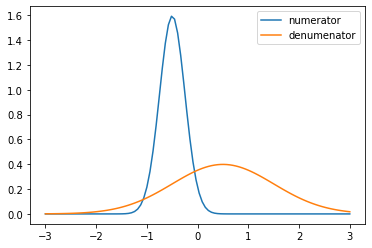

In [ ]:
# distributions

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
from torch.optim import Adam
from tqdm.notebook import tqdm
from sklearn.metrics.pairwise import rbf_kernel

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class KMM(nn.Module):
  def __init__(self, hd=128):
    super().__init__()
    self.r = nn.Sequential(nn.Linear(1, hd), 
                               nn.ReLU(),
                               nn.Linear(hd, hd), 
                               nn.ReLU(),
                               nn.Linear(hd, 1),
                               nn.Softplus())
    
  def fit(self, data_nu, data_de, batch_size=512, lr=1e-3, num_epochs=1000):
    optim = Adam(self.r.parameters(), lr=lr)

    for epoch in tqdm(range(num_epochs)):
      for (batch_nu, batch_de) in zip(data_nu, data_de):
        n = batch_nu.shape[0]
        batch_nu = batch_nu.view(-1, 1).float().to(device)
        batch_de = batch_de.view(-1, 1).float().to(device)

        r_de = self.r(batch_de)
        kernel_de = rbf_kernel(batch_de.cpu(), batch_de.cpu(), gamma=5)
        kernel_de = torch.tensor(kernel_de).to(device)
        kernel_nu = rbf_kernel(batch_de.cpu(), batch_nu.cpu(), gamma=5)
        kernel_nu = torch.tensor(kernel_nu).to(device)

        first = r_de.T.matmul(kernel_de).matmul(r_de)
        second = r_de.T.matmul(kernel_nu).matmul(torch.ones_like(batch_nu))
        loss = (first - 2 * second) / n ** 2

        optim.zero_grad()
        loss.backward()
        optim.step()

  def predict(self, data):
    return self.r(data).detach().cpu().numpy()


In [ ]:
params = {'batch_size': 512,
          'hd': 128,
          'lr': 1e-3, 
          'num_epochs': 1000}

In [ ]:
def q1(data_nu, data_de):
  """
  data_nu - An [n_nu] dataset with samples from numerator's distribution
  data_de - An [n_de] dataset with samples from denominators's distribution
  
  Returns
    - a np.array with density ratios of np.linspace(-2., 2, num=100)
  """
  # your code goes here

  # you need to calculate density ratio on x and return it
  # x = np.linspace(-2., 2, num=100)

  kmm = KMM(hd=params['hd']).to(device)
  loader_nu = data.DataLoader(data_nu, 
                              batch_size=params['batch_size'], 
                              shuffle=True)
        
  loader_de = data.DataLoader(data_de, 
                              batch_size=params['batch_size'], 
                              shuffle=True)
  kmm.fit(loader_nu, 
          loader_de, 
          batch_size=params['batch_size'], 
          lr=params['lr'], 
          num_epochs=params['num_epochs'])
  
  x = np.linspace(-2., 2, num=100)
  x = torch.tensor(x).reshape(-1, 1).float().to(device)
  x_hat = kmm.predict(x)
  
  return x_hat  


  0%|          | 0/1000 [00:00<?, ?it/s]

<Figure size 432x288 with 0 Axes>

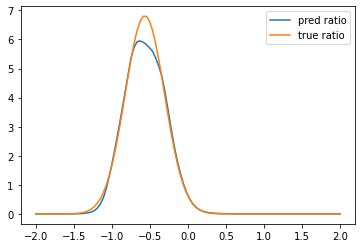

In [ ]:
# q1_results(q1)

# Question 2. AVB

Here we will implement [Adversairal Variational Bayes](https://dl.acm.org/doi/pdf/10.5555/3305890.3305928).

You may experiment with different hyperparameters and architecture designs, but the following designs for the AVB architecture may be useful.

```
Classifier (T)
    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(),
    # reshape + add latent
    Linear(4 * 4 * 128 + ld, hd), 
    ReLU(),
    Linear(hd, hd), 
    ReLU(),
    Linear(hd, 1)


Encoder (E)

    Conv2d(1, 32, 3, 1, 1), 
    ReLU(),
    Conv2d(32, 64, 3, 2, 1),
    ReLU(), 
    Conv2d(64, 128, 3, 2, 1), 
    ReLU(), 
    Conv2d(128, 128, 3, 2, 1), 
    ReLU(), 
    # add noise + reshape
    Linear(4 * 4 * 128 + nd, ld)

Decoder (D)
    ConvTranspose2d(128, 128, 3, 2, 1), 
    ReLU(), 
    ConvTranspose2d(128, 64, 4, 2, 1), 
    ReLU(), 
    ConvTranspose2d(64, 32, 4, 2, 1), 
    ReLU(), 
    Conv2d(32, 1, 3, 1, 1)
    # reshape
    Linear(ld, 4 * 4 * 128), 
    ReLU()
```

**Reminder.** Objective for AVB

$$max_{\theta, \phi} E \log p_\theta(x|z_\phi(x)) - T(x, z_\phi(x))$$
$$max_{T} E_x \bigg(E_{q_\phi(z|x)} \log\big(\sigma (T(x, z))\big) + E_{p(z)} \log\big(1 - \sigma (T(x, z))\big)\bigg) $$

$\phi$ - parameters of encoder, $\theta$ - parameters of decoder


**You will provide the following deliverables**


1.   Over the course of training, record the elbo and loss of the classifier T ber batch.
2. Report the final test set performances of your final models
3. 100 samples from your trained AVB

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader
import torch.optim as opt
import numpy as np
from torch.distributions import MultivariateNormal
from torch.optim import Adam

from tqdm.notebook import tqdm

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.autograd.set_detect_anomaly(True)

In [46]:
class Encoder(nn.Module):
  def __init__(self, latent_dim, noise, const=4 * 4 * 128):
    super().__init__()
    self.latent_dim = latent_dim
    self.noise = noise
    self.const = const

    self.seq = nn.Sequential(nn.Conv2d(1, 32, 3, 1, 1),
                              nn.ReLU(),
                              nn.Conv2d(32, 64, 3, 2, 1),
                              nn.ReLU(), 
                              nn.Conv2d(64, 128, 3, 2, 1), 
                              nn.ReLU(), 
                              nn.Conv2d(128, 128, 3, 2, 1), 
                              nn.ReLU())
    self.linear = nn.Linear(self.const + self.noise, self.latent_dim)

  def forward(self, data, noise):
    data = self.seq(data).flatten(start_dim=1)
    data = torch.cat((data, noise), 1)
    output = self.linear(data)
    return output


class Decoder(nn.Module):
  def __init__(self, latent_dim, const=4 * 4 * 128):
    super().__init__()
    self.latent_dim = latent_dim
    self.const = const

    self.seq = nn.Sequential(nn.ConvTranspose2d(128, 128, 3, 2, 1), 
                              nn.ReLU(), 
                              nn.ConvTranspose2d(128, 64, 4, 2, 1), 
                              nn.ReLU(), 
                              nn.ConvTranspose2d(64, 32, 4, 2, 1), 
                              nn.ReLU(), 
                              nn.Conv2d(32, 1, 3, 1, 1),
                              nn.Tanh())
    self.linaer = nn.Sequential(nn.Linear(self.latent_dim, self.const),
                                nn.ReLU())
    
  def forward(self, data):
    data = self.linaer(data)
    data = data.view(-1, 128, 4, 4)
    output = self.seq(data)
    return output


class Classifier(nn.Module):
  def __init__(self, latent_dim, hidden_dim, const=4 * 4 * 128): 
    super().__init__()
    self.latent_dim = latent_dim
    self.hidden_dim = hidden_dim
    self.const = const

    self.seq = nn.Sequential(nn.Conv2d(1, 32, 3, 1, 1),
                              nn.ReLU(),
                              nn.Conv2d(32, 64, 3, 2, 1),
                              nn.ReLU(), 
                              nn.Conv2d(64, 128, 3, 2, 1), 
                              nn.ReLU(), 
                              nn.Conv2d(128, 128, 3, 2, 1), 
                              nn.ReLU())
    self.linear = nn.Sequential(nn.Linear(self.const + self.latent_dim, self.hidden_dim), 
                                nn.ReLU(),
                                nn.Linear(self.hidden_dim, self.hidden_dim), 
                                nn.ReLU(),
                                nn.Linear(self.hidden_dim, 1))
    
  def forward(self, data, z):
    data = self.seq(data).flatten(start_dim=1)
    data = torch.cat((data, z), 1)
    output = self.linear(data)
    return output

In [51]:
class AVB(nn.Module):
  def __init__(self, latent_dim, hidden_dim, noise):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.latent_dim = latent_dim

    self.zeroes_ld = torch.full((self.latent_dim,), 0.0, dtype=torch.float, device=device)
    self.diagonal_ld = torch.eye(self.latent_dim, dtype=torch.float, device=device)
    self.latent_distribution = MultivariateNormal(self.zeroes_ld, self.diagonal_ld)

    self.noise = noise
    self.zeroes_n = torch.full((self.noise,), 0.0, dtype=torch.float, device=device)
    self.diagonal_n = torch.eye(self.noise, dtype=torch.float, device=device)
    self.noise_distribution = MultivariateNormal(self.zeroes_n, self.diagonal_n)        
    
    self.T = Classifier(self.latent_dim, self.hidden_dim)
    self.E = Encoder(self.latent_dim, self.noise)
    self.D = Decoder(self.latent_dim)
  
  def get_losses(self, data):
    data = data.to(device)
    size = data.shape[0]

    sample_noise = self.noise_distribution.sample((size,))
    encode_d_n = self.E(data, sample_noise)
    recon_data = self.D(encode_d_n)
    loss_record = F.mse_loss(recon_data, data, reduction="none")
    loss_record = loss_record.reshape(size, -1)
    loss_record = loss_record.sum(1)
    loss_record_T = self.T(data, encode_d_n)
    elbo = loss_record + loss_record_T
    elbo = elbo.mean()

    with torch.no_grad():
      for_class_real = self.E(data, self.noise_distribution.sample((size,)))
    for_class_fake = self.latent_distribution.sample((size,))

    sigmoid_real = torch.sigmoid(self.T(data, for_class_real))
    # for_class_real_ones = torch.ones_like(sigmoid_real)
    for_class_real_ones = torch.full(sigmoid_real.shape, 1.0)
    # print(sigmoid_real.shape)
    # print(for_class_real_ones.shape)
    for_class_real_loss = F.binary_cross_entropy(sigmoid_real.to(device), for_class_real_ones.to(device))

    sigmoid_fake = torch.sigmoid(self.T(data, for_class_fake))
    # for_class_fake_zero = torch.zeros_like(sigmoid_fake)
    for_class_fake_zero = torch.full(sigmoid_fake.shape, 0.0)
    for_class_fake_loss = F.binary_cross_entropy(sigmoid_fake.to(device), for_class_fake_zero.to(device))
    
    classification = for_class_real_loss + for_class_fake_loss
    classification = classification.mean()

    return elbo, classification 

  def for_test(self, data):
    with torch.no_grad():
      self.eval()
      elbo_loss, classification_loss = [], []

      for batch in data:
        batch = batch.to(device)
        elbo, classification = self.get_losses(batch)
        elbo_loss.append(elbo.item())
        classification_loss.append(classification.item())
      elbo_loss = np.asarray(elbo_loss).mean()
      classification_loss = np.asarray(classification_loss).mean()
    return [elbo_loss, classification_loss]

  def fit(self, train_data, test_data, lr, epochs):
    optim_class = Adam(self.T.parameters(), lr=lr) 
    opt_E_param = list(self.E.parameters())
    opt_D_param = list(self.D.parameters())
    optim_E_D = Adam(opt_E_param + opt_D_param, lr=lr)

    loss_train, loss_test = [], []
    loss_test.append(self.for_test(test_data))

    for epoch in tqdm(range(epochs)):
      for batch in train_data:
        batch = batch.to(device)

        elbo, classification = self.get_losses(batch)

        optim_E_D.zero_grad()
        elbo.backward()
        optim_E_D.step()

        optim_class.zero_grad()
        classification.backward()
        optim_class.step()
        
        loss_train_list = [elbo.item(), classification.item()]
        loss_train.append(loss_train_list)

      loss_test.append(self.for_test(test_data))
    loss_train = np.array(loss_train)
    loss_test = np.array(loss_test)
    return loss_train[:, 0], loss_train[:, 1], loss_test[:, 0], loss_test[:, 1]
  
  def get_smples(self, n):
    out = torch.sigmoid(self.D(self.latent_distribution.sample((n, ))))
    out = out.detach().cpu().numpy()
    return out 
  # def get_samples(self, n):
  #   out = self.D(self.latent_distribution.sample((n, )))
  #   out = out.clip(-1, 1) * 0.5 + 0.5
  #   out = out.cpu().numpy()
  #   return out

In [48]:
params = {'latent_dim': 64, 
          'hidden_dim': 256, 
          'noise': 16,
          'batch_size': 256,
          'lr': 1e-3,
          'epochs': 20,
          'n': 100}

In [52]:
def q2(train_data, test_data):
  """
  train_data - A (n_train, 28, 28, 1) uint8 numpy array of binary images with values in {0, 1}
   Returns
  - a (# of training iterations,) numpy array of elbo_losses evaluated every minibatch
  - a (# of training iterations,) numpy array of classifier_losses evaluated every minibatch
  - a torch tensor of size (100, 1, 28, 28) of samples with values in {0, 1}
  """

  train = DataLoader(torch.tensor(np.transpose(train_data, (0, 3, 1, 2)), dtype=torch.float32), 
                    batch_size=params['batch_size'], 
                    shuffle=True)
  test = DataLoader(torch.tensor(np.transpose(test_data, (0, 3, 1, 2)), dtype=torch.float32),
                    batch_size=params['batch_size'], 
                    shuffle=True)

  model_AVB = AVB(latent_dim=params['latent_dim'], 
                  hidden_dim=params['hidden_dim'], 
                  noise=params['noise'])
  model_AVB = model_AVB.to(device)
  print('done with init')
  loss_train_0, loss_train_1, loss_test_0, loss_test_1 = model_AVB.fit(train, 
                                                                        test, 
                                                                        lr=params['lr'],
                                                                        epochs=params['epochs'])
  print('done with losses')  
  sample = model_AVB.get_smples(params['n'])
  print('done with samples')  

  return loss_train_0, loss_train_1, loss_test_0, loss_test_1, sample

done with init


  0%|          | 0/20 [00:00<?, ?it/s]

done with losses
done with samples


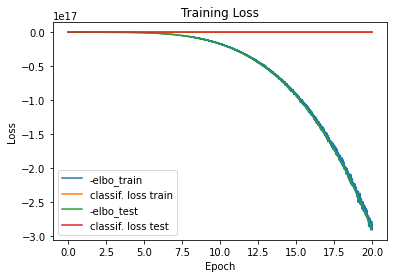

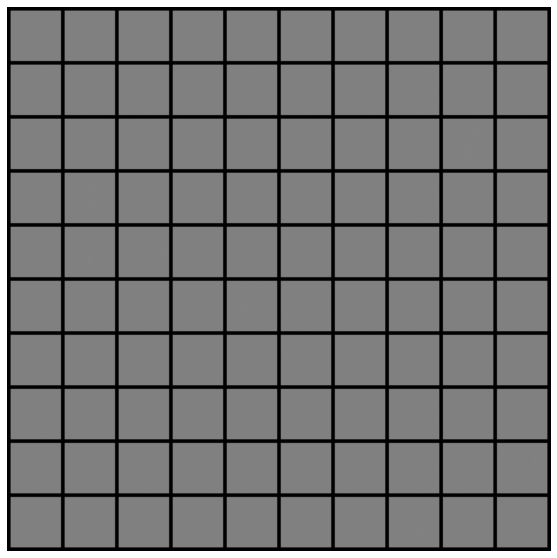

In [53]:
q2_results(q2)